In [ ]:
connections = [(7,8),(6,7),(2,6),(2,12),(12,13),(13,14),(2,0),(0,3),(0,9),(3,4),(4,5),(9,10),(10,11),(0,16)]

In [2]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return x, self.layers(x)

def get_simclr_net():
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.fc = MLP(2048, 2048, 128)

    return model

class Projector(nn.Module):
    def __init__(self, input_dim, out_dim, hidder_proj):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, hidder_proj),
            nn.BatchNorm1d(hidder_proj),
            nn.ReLU(inplace=True),

            nn.Linear(hidder_proj, hidder_proj),
            nn.BatchNorm1d(hidder_proj),
            nn.ReLU(inplace=True),

            nn.Linear(hidder_proj, out_dim),
        )

    def forward(self, x):
        return x, self.proj(x)

class SiamMLP(nn.Module):
    def __init__(self, base, input_dim, out_dim, hidder_proj, hidden_pred):
        super().__init__()

        self.base = base

        base.fc = Projector(input_dim, out_dim, hidder_proj)

        self.predictor = nn.Sequential(
            nn.Linear(out_dim, hidden_pred),
            nn.BatchNorm1d(hidden_pred),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_pred, out_dim)
        )


    def forward(self, x):
        x, projections =  self.base(x)

        predictions = self.predictor(projections)

        return x, projections.detach(), predictions

def get_siam_net():
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model = SiamMLP(model, 2048, 2048, 2048, 512)

    return model

In [3]:
import os
import torch
import math
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import json
import cv2
import re
import random
import torchvision.transforms as transforms
from torchvision.io import read_image

import matplotlib.pyplot as plt
import torchvision.transforms as T



class PanopticDataset(Dataset):
    def __init__(self, transform):

        # change this to the path where the dataset is stored
        self.data_path = "ProcessedPanopticDataset\\"
        self.training_dir = []

        self.transform = transform

        paths = []

        motion_seq = os.listdir(self.data_path)
        no_dir = ['scripts','python','matlab','.git','glViewer.py','README.md','matlab',
                'README_kinoptic.md']

        for dir in motion_seq:
            if dir not in no_dir:
                if 'haggling' in dir:
                    continue
                elif dir == '171204_pose2' or dir =='171204_pose5' or dir =='171026_cello3':
                    if os.path.exists(os.path.join(self.data_path,dir,'hdJoints')):
                        data_path = os.path.join(self.data_path,dir,'hdJoints')
                        for lists in (os.listdir(data_path)):
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))
                elif 'ian' in dir:
                    continue
                else:
                    if os.path.exists(os.path.join(self.data_path,dir,'hdJoints')):
                        data_path = os.path.join(self.data_path,dir,'hdJoints')
                        for lists in (os.listdir(data_path)):
                            
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))

        self.data = {'paths': paths}

    def __len__(self):
        return len(self.data['paths'])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = dict()

        path_split = self.data['paths'][idx].split('\\hdJoints')
        image_path = path_split[0] + '\\hdImages' + path_split[-1] + '.jpg'

        image = cv2.imread(image_path)
        image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)

        sample['image'] = image

        joints_path = self.data['paths'][idx]+'.json'

        with open(joints_path) as dfile:
            bframe = json.load(dfile)

        poses_3d = torch.tensor(np.array(bframe['poses_3d']), dtype=torch.float32)
        #remove every 4th element of one dimensional array poses_3d
        poses_3d = poses_3d.reshape(-1, 4)[:, :3].reshape(-1)

        sample['poses_3d'] =  poses_3d

        cam = bframe['cam']
        # Replace 'array' with 'list' in the cam string
        cam = cam.replace('array', 'list')

        sample['cam'] = cam

        return sample

In [4]:
# uncomment this if you get an No module named 'pytorch_lightning.utilities.apply_func' error
# !pip3 install pytorch-lightning==1.2.2

### On top of a base encoder, a simple linear layer is attached that predicts 19 pairs of joints. The base encoder can be either SimCLR or Siamese models. I remove the projection head (or projection and prediction in case of Siamese) and use only the output of the base encoder, which is the output of AvrPool layer.

In [5]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.layers = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 18*3))


    def forward(self, x):
        z = self.layers(x)
        return z

In [6]:
def get_linear_evaluation_model(path, base, siam=True):

    base.load_state_dict(torch.load(path, map_location=torch.device('cuda')))

    if siam:
        base = base.base
        base.fc = Linear()
    else:
        base.fc = Linear()

    return base

### I freeze all the layers of the base encoder and use Stochastic gradient descent to train only the linear layer.

In [7]:
from torch.optim import SGD
from torch.optim import Adam


def get_optimizer(net, learning_rate, weight_decay, momentum=0.0):
    final_layer_weights = []
    rest_of_the_net_weights = []

    for name, param in net.named_parameters():
        #if from linear layer then add to final_layer_weights otherwise set requires_grad to false
        if 'fc' in name:
            final_layer_weights.append(param)
        else:
            rest_of_the_net_weights.append(param)
            param.requires_grad = False
        
    #print (final_layer_weights)

    optimizer = Adam(final_layer_weights, weight_decay=weight_decay, lr=learning_rate)
    #optimizer = SGD([ {'params': final_layer_weights, 'lr': learning_rate} ], weight_decay=weight_decay, momentum=momentum)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    return optimizer, scheduler

### The images are resized into (128, 128) since the models were trained using this size. The dataset is split into 60%/20%/20% for training, validation and testing.

In [8]:
generator = torch.Generator().manual_seed(42)

def get_data(batch_size):

    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Resize(size=(128, 128)),
        ]
    )

    data = PanopticDataset(transforms)

    num_samples = len(data)

    training_samples = int(num_samples * 0.6 + 1)
    val_samples = int(num_samples * 0.2 + 1)
    test_samples = num_samples - training_samples - val_samples

    training_data, val_data, test_data = torch.utils.data.random_split(
        data, [training_samples, val_samples, test_samples], generator=generator
    )

    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

    return training_data, val_data, test_data, train_loader, val_loader, test_loader

c:\Users\david\Documents\PROGETTI\SIV\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


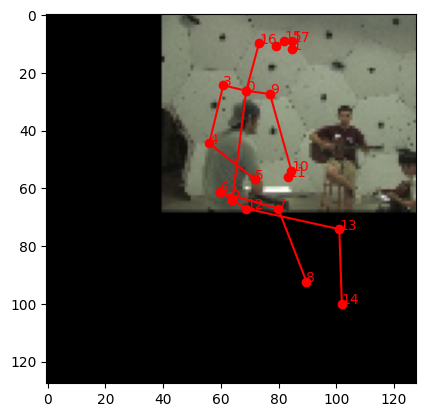

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming your get_data function returns appropriate data
training_data, _, _, _, _, _ = get_data(201)

image = training_data[9]['image']
coords = training_data[9]['poses_3d'].reshape((-1, 3))
cam = training_data[9]['cam']


def project_points( points_3d, camera_parameters_str):
    # Load camera parameters
    camera_params = eval(camera_parameters_str)

    # Camera intrinsic matrix
    K = camera_params['K']

    # Rotation matrix and translation vector
    R = camera_params['R']
    t = camera_params['t']

    # Projection matrix
    P = np.dot(K, np.hstack((R, t)))

    # Homogeneous 3D points
    points_3d_homogeneous = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))

    # Project 3D points to 2D
    points_2d_homogeneous = np.dot(P, points_3d_homogeneous.T).T

    # Normalize homogeneous coordinates
    points_2d = points_2d_homogeneous[:, :2] / points_2d_homogeneous[:, 2:]

    # rseize to 128x128
    points_2d[:, 0] = points_2d[:, 0] * 128 / 1080
    points_2d[:, 1] = points_2d[:, 1] * 128 / 1080

    # center points, 2 is the center of the image
    points_2d[:, 0] = points_2d[:, 0] + 64 - points_2d[2, 0]
    points_2d[:, 1] = points_2d[:, 1] + 64 - points_2d[2, 1]

    return points_2d

points = project_points(coords, cam)


#plot image with points
plt.imshow(image.permute(1, 2, 0))
plt.scatter(points[:, 0], points[:, 1], c='r')

#show number of points
for i in range(18):
    plt.text(points[i, 0], points[i, 1], str(i), color='r')

#connect points 7-8 6-7 2-6 2-12 12-13 13-14 2-0 0-3 0-9 3-4 4-5 9-10 10-11 0-16
for connection in connections:
    plt.plot(points[connection, 0], points[connection, 1], c='r')


plt.show()


### The loss function that is used for training is L2 loss. As an accuracy metrics I report average euclidean distance between true and predicted joints. The model is also trained for 20 epochs.

In [10]:
def find_rotation_mat(points1, points2):
    """
    Function to find the rotation matrix between two sets of ordered 3D points.

    Parameters:
    - points1: input containing a set of ordered 3D points
    - points2: target containing the reference set of ordered 3D points

    Returns:
    - transformation_matrix: torch.Tensor, 3x3 transformation matrix
    """

    # Calculate the covariance matrix 
    covariance_matrix = torch.mm(points1.t(), points2)

    # Calculate the singular value decomposition
    U, S, V = torch.svd(covariance_matrix)

    # Calculate the rotation matrix
    rotation_matrix = torch.mm(V, U.t())

    # special reflection case
    if torch.det(rotation_matrix) < 0:
        U, S, V = torch.svd(covariance_matrix)
        V[2, :] *= -1
        rotation_matrix = torch.mm(V, U.t())

    return rotation_matrix

In [11]:
def find_scaling(points1, points2):
    """
    Function to find the scaling factor between two sets of ordered 3D points.

    Parameters:
    - points1: input containing a set of ordered 3D points
    - points2: target containing the reference set of ordered 3D points

    Returns:
    - scaling_factor: torch.Tensor, 1x1 scaling factor
    """
    points1 = points1.view(-1)
    points2 = points2.view(-1)

    # Calculate the scaling factor
    scaling_factor = torch.sum(points2 * points1) / torch.sum(points1 * points1)

    return scaling_factor

In [12]:
# get loss for the whole batch
def get_loss(output, pose, weights=None, norm_factor=0.2):
    batch_size = output.shape[0]

    # vectors are a column vector and should be grouped by 3 (x, y, z)
    output = output.view(batch_size, -1, 3)
    pose = pose.view(pose.shape[0], -1, 3)

    # add first point to output (0,0,0) for each batch
    output = torch.cat((torch.zeros((batch_size, 1, 3)).to("cuda"), output), 1)

    # center pose on first point for each batch
    pose = pose - pose[:, 0].unsqueeze(1)

    #find rotation matrix for each batch
    batch_rotation_matrix = torch.zeros((batch_size, 3, 3)).to("cuda")
    # scaling_factor = torch.zeros((batch_size, 1)).to("cuda")

    with torch.no_grad():
        #center pose on first point for each batch
        pose = pose - pose[:, 0].unsqueeze(1)

        #print ("output before\n", output)

        for i in range(batch_size):
            #print(output[i])
            rotation_matrix = find_rotation_mat(pose[i], output[i])
            
            batch_rotation_matrix[i] = rotation_matrix

    output = torch.bmm(output, batch_rotation_matrix)

    '''
    #find scaling factor for each batch

    with torch.no_grad():
        for i in range(batch_size):
            scaling_factor[i] = find_scaling(pose[i], output[i])
        
    for i in range(batch_size):
        output[i] = output[i] * scaling_factor[i].item()
    '''

    #print ("output\n", output)
    #print ("pose\n", pose)
    #mean squared error for each batch
    loss = torch.mean((pose - output)**2)
    #print(loss)

    # add L2 normalization factor for weights
    if weights is not None:
        weights = weights.view(-1)
        loss += norm_factor * torch.sum(weights**2)

    return loss

In [13]:
from tqdm import tqdm



def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
    batches = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0
    samples = 0.0

    net.train()

    for batch_idx, batch in enumerate(tqdm(data_loader)):

        images = batch['image']
        poses = batch['poses_3d']

        images = images.to(device)
        poses = poses.to(device)

        output = net(images)

        loss = cost_function(output, poses)
        cumulative_loss += loss.item()

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        batches += 1
        samples += images.shape[0]

        cumulative_accuracy += torch.cdist(output, poses[:,3:], 2).mean()

    return cumulative_loss / batches, cumulative_accuracy / samples


def test_step(net, data_loader, cost_function, device='cuda'):
    batches = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.
    samples = 0.

    net.eval()

    with torch.no_grad():

        for batch_idx, batch in enumerate(tqdm(data_loader)):
            images = batch['image']
            poses = batch['poses_3d']

            images = images.to(device)
            poses = poses.to(device)

            output = net(images)

            loss = cost_function(output, poses)
            cumulative_loss += loss.item()

            batches += 1
            samples += images.shape[0]
            cumulative_accuracy += torch.cdist(output, poses[:,3:], 2).mean()

    return cumulative_loss / batches, cumulative_accuracy / samples

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="trained_models/tensorboard", filename_suffix="_linear_eval")

def main(path, base, batch_size=128, device='cuda', learning_rate=0.001, weight_decay=0.000001, momentum=0.9, epochs=20, siam=False):
    _, _, _, train_loader, val_loader, test_loader = get_data(batch_size)

    net = get_linear_evaluation_model(path, base, siam=siam).to(device)
    epoch = 0

    if (siam):
        info_file = "trained_models/siam/siam_linear.txt"
        model_file = "trained_models/siam/siam_linear_epoch"
        model_dir = "trained_models/siam"
        optimizer_file = "trained_models/siam/siam_linear_optimizer"
        scheduler_file = "trained_models/siam/siam_linear_scheduler"
        tensorboard_tag = "siam_linear"
    else:
        info_file = "trained_models/sim/sim_linear.txt"
        model_file = "trained_models/sim/sim_linear_epoch"
        model_dir = "trained_models/sim"
        optimizer_file = "trained_models/sim/sim_linear_optimizer_epoch"
        scheduler_file = "trained_models/sim/sim_linear_scheduler_epoch"
        tensorboard_tag = "sim_linear"

    #load weights
    if os.path.exists(model_dir):
        files = os.listdir(model_dir)
        #remove .txt file
        if len(files) > 1:
            files.remove(info_file.split('/')[-1])
            epoch = max([int(re.findall(r'\d+', file)[0]) for file in files])
            net.load_state_dict(torch.load(model_file+str(epoch)+'.pt', map_location=torch.device('cuda')))
            print("Loaded weights from epoch", epoch)
        else:
            print("No weights found")
            f = open(info_file, "w")
            f.close()

        
    optimizer, scheduler = get_optimizer(net, learning_rate, weight_decay, momentum)
    if os.path.exists(optimizer_file+str(epoch)+'.pt'):
        print("Loaded optimizer from epoch", epoch)
        optimizer.load_state_dict(torch.load(optimizer_file+str(epoch)+'.pt'))
        scheduler.load_state_dict(torch.load(scheduler_file+str(epoch)+'.pt'))

    cost_function = get_loss

    for e in range(epoch, epochs):

        train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function, device)
        val_loss, val_accuracy = test_step(net, val_loader, cost_function, device)

        scheduler.step()

        print('Epoch: {:d}'.format(e+1))
        print('\tTraining loss {:.5f}, Training Acc {:.4f}'.format(train_loss, train_accuracy))
        print('\tValidation loss {:.5f}, Validation Acc {:.2f}'.format(val_loss, val_accuracy))
        print('-----------------------------------------------------')

        torch.save(net.state_dict(), model_file+str(e+1)+'.pt')
        torch.save(optimizer.state_dict(), optimizer_file+str(e+1)+'.pt')
        torch.save(scheduler.state_dict(), scheduler_file+str(e+1)+'.pt')
        #write information to file
        f = open(info_file, "a")
        f.write('Epoch: {:d}\n'.format(e+1))
        f.write('\tTraining loss {:.5f}, Training Acc {:.4f}\n'.format(train_loss, train_accuracy))
        f.write('\tValidation loss {:.5f}, Validation Acc {:.2f}\n'.format(val_loss, val_accuracy))
        f.write('-----------------------------------------------------\n')
        f.close()

        writer.add_scalar(tensorboard_tag+'/Loss/train', train_loss, e+1)
        writer.add_scalar(tensorboard_tag+'/Loss/val', val_loss, e+1)
        writer.add_scalar(tensorboard_tag+'/Accuracy/train', train_accuracy, e+1)
        writer.add_scalar(tensorboard_tag+'/Accuracy/val', val_accuracy, e+1)
        writer.add_scalar(tensorboard_tag+'/lr', scheduler.get_last_lr()[0], e+1)
        writer.flush()

    print('After training:')
    train_loss, train_accuracy = test_step(net, train_loader, cost_function, device)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function, device)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function, device)

    print('\tTraining loss {:.5f}, Training Acc {:.4f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation Acc {:.4f}'.format(val_loss, val_accuracy))
    print('\tTest loss {:.5f}, Test Acc {:.4f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    #write information to file
    f = open(info_file, "a")
    f.write('After training:\n')
    f.write('\tTraining loss {:.5f}, Training Acc {:.4f}\n'.format(train_loss, train_accuracy))
    f.write('\tValidation loss {:.5f}, Validation Acc {:.4f}\n'.format(val_loss, val_accuracy))
    f.write('\tTest loss {:.5f}, Test Acc {:.4f}\n'.format(test_loss, test_accuracy))
    f.write('-----------------------------------------------------\n')
    f.close()


In [15]:
simclr_path = 'trained_models/ver1.pt'

simclr = get_simclr_net()

main(simclr_path, simclr, epochs=30, siam=False, learning_rate=0.03)

No weights found


100%|██████████| 480/480 [13:37<00:00,  1.70s/it]


Epoch: 1
	Training loss 38.30630, Training Acc 4.5809
	Validation loss 27.56716, Validation Acc 4.62
-----------------------------------------------------


100%|██████████| 480/480 [13:12<00:00,  1.65s/it]


Epoch: 2
	Training loss 26.84827, Training Acc 4.6020
	Validation loss 25.70868, Validation Acc 4.59
-----------------------------------------------------


100%|██████████| 480/480 [13:33<00:00,  1.69s/it]


Epoch: 3
	Training loss 25.65431, Training Acc 4.6062
	Validation loss 25.64909, Validation Acc 4.59
-----------------------------------------------------


100%|██████████| 480/480 [13:12<00:00,  1.65s/it]


Epoch: 4
	Training loss 25.02166, Training Acc 4.6096
	Validation loss 24.57324, Validation Acc 4.63
-----------------------------------------------------


100%|██████████| 480/480 [13:27<00:00,  1.68s/it]


Epoch: 5
	Training loss 24.73496, Training Acc 4.6109
	Validation loss 24.62242, Validation Acc 4.63
-----------------------------------------------------


100%|██████████| 480/480 [13:14<00:00,  1.65s/it]


Epoch: 6
	Training loss 24.42686, Training Acc 4.6103
	Validation loss 23.54633, Validation Acc 4.61
-----------------------------------------------------


100%|██████████| 480/480 [13:40<00:00,  1.71s/it]


Epoch: 7
	Training loss 24.14671, Training Acc 4.6062
	Validation loss 23.40355, Validation Acc 4.61
-----------------------------------------------------


100%|██████████| 480/480 [18:01<00:00,  2.25s/it]


Epoch: 8
	Training loss 26.48417, Training Acc 4.6030
	Validation loss 25.91026, Validation Acc 4.62
-----------------------------------------------------


100%|██████████| 480/480 [12:42<00:00,  1.59s/it]


Epoch: 9
	Training loss 25.79577, Training Acc 4.6011
	Validation loss 25.25047, Validation Acc 4.62
-----------------------------------------------------


100%|██████████| 480/480 [13:08<00:00,  1.64s/it]


Epoch: 10
	Training loss 25.01048, Training Acc 4.6033
	Validation loss 23.55144, Validation Acc 4.60
-----------------------------------------------------


 23%|██▎       | 329/1438 [08:03<27:10,  1.47s/it]


KeyboardInterrupt: 

In [ ]:
siam_path = 'trained_models/siam2.pt'

siam = get_siam_net()

main(siam_path, siam, epochs=20, siam=True)

In [ ]:
#rename all tags sim_linear with sim_linear_2_layers in tensorboard
